In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
import progressbar
import igraph
from sklearn.neighbors import LSHForest
import random
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import euclidean_distances
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Parameters

In [3]:
n_latent = 100 # number of latent variables in LDA

In [5]:
def get_user_genre_matrix(data):
    # return matrix of size n_users*n_genres with cf_mat[i,j]==n if user i listened to genre j n times
    # and mappings user_id -> row of matrix, genre_id -> column of matrix
    user_ids = dict([(j,i) for  i,j in enumerate(data['user_id'].unique())])
    genre_ids = dict([(j,i) for  i,j in enumerate(data['genre_id'].unique())])
    n_users = len(user_ids)
    n_genres = len(genre_ids)
    cf_mat = sparse.dok_matrix((n_users,n_genres))
    for i, r in enumerate(data.iterrows()):
        if r[1]['is_listened']:
            cf_mat[user_ids[r[1]['user_id']],genre_ids[r[1]['genre_id']]] += 1
        if i % 400000 == 0:
            print '%d%%' % (float(i)/data.shape[0]*100)
    return user_ids, genre_ids, cf_mat
def get_user_media_matrix(data):
    # return matrix of size n_users*n_medias with cf_mat[i,j]==n iff user i listened to media j n times
    # and mappings user_id -> row of matrix, media_id -> column of matrix
    user_ids = dict([(j,i) for  i,j in enumerate(data['user_id'].unique())])
    media_ids = dict([(j,i) for  i,j in enumerate(data['media_id'].unique())])
    n_users = len(user_ids)
    n_medias = len(media_ids)
    cf_mat = sparse.dok_matrix((n_users,n_medias))
    for i, r in enumerate(data.iterrows()):
        if r[1]['is_listened']:
            cf_mat[user_ids[r[1]['user_id']],media_ids[r[1]['media_id']]] += 1
        if i % 400000 == 0:
            print '%d%%' % (float(i)/data.shape[0]*100)
    return user_ids, media_ids, cf_mat

In [42]:
def add_ids(ids, vectors):
# add ids from dictionary 'ids' to matrix 'vectors' as a column
    vectors_ext = np.zeros([vectors.shape[0], vectors.shape[1]+1])
    vectors_ext[:vectors.shape[0],:vectors.shape[1]] = vectors
    for j,i in ids.iteritems():
        vectors_ext[i,vectors.shape[1]] = j
    return vectors_ext

def extract_ids(vectors_ext):
# extract ids to dictionary 'ids' from last column of matrix 'vectors_ext'
    vectors = vectors_ext[:vectors_ext.shape[0],:-1]
    ids = {}
    for i in range(vectors_ext.shape[0]):
        ids[vectors_ext[i,-1]] = i
    return ids, vectors

### calculate and dump user and media vectors

In [10]:
train_data = pd.read_csv('data/train.csv',sep=',', usecols=['media_id','user_id','is_listened'])
test_data = pd.read_csv('data/test.csv',sep=',', usecols=['media_id','user_id'])

In [15]:
user_ids, media_ids, user_media_matrix = get_user_media_matrix(train_data)

0%
5%
10%
15%
21%
26%
31%
37%
42%
47%
52%
58%
63%
68%
74%
79%
84%
89%
95%


In [16]:
lda = LatentDirichletAllocation(n_topics=n_latent, learning_method='batch').fit(user_media_matrix)
user_vectors = lda.transform(user_media_matrix)
media_vectors = lda.components_.T

In [19]:
user_vectors_ext = add_ids(user_ids, user_vectors)
with open('user_vectors.npy','w') as f:
    np.save(f, user_vectors_ext)

In [20]:
media_vectors_ext = add_ids(media_ids, media_vectors)
with open('media_vectors.npy','w') as f:
    np.save(f, media_vectors_ext)

### load user and media vectors and calculate similarity

In [43]:
with open('user_vectors.npy','r') as f:
    user_vectors_ext = np.load(f)
user_ids, user_vectors = extract_ids(user_vectors_ext)

In [44]:
with open('media_vectors.npy','r') as f:
    media_vectors_ext = np.load(f)
media_ids, media_vectors = extract_ids(media_vectors_ext)

In [45]:
c = 0
def similarity(user_id,media_id):
    # return cosine similarity between users and medias
    # return 0 for unknown users and medias
    global c
    c += 1
    if c%300000==0:
        print c
    if user_id in user_ids and media_id in media_ids:
        i = user_ids[user_id]
        j = media_ids[media_id]
        return float(cosine_similarity(user_vectors[i,:].reshape([1,-1]),media_vectors[j,:].reshape([1,-1])))
    return 0.

In [49]:
train_data['similarity'] = train_data[['user_id','media_id']].apply(lambda rec : similarity(rec['user_id'],rec['media_id']), axis=1)

300000
600000
900000
1200000
1500000
1800000
2100000
2400000
2700000
3000000
3300000
3600000
3900000
4200000
4500000
4800000
5100000
5400000
5700000
6000000
6300000
6600000
6900000
7200000
7500000


In [50]:
test_data['similarity'] = test_data[['user_id','media_id']].apply(lambda rec : similarity(rec['user_id'],rec['media_id']), axis=1)

<IPython.core.display.Javascript object>


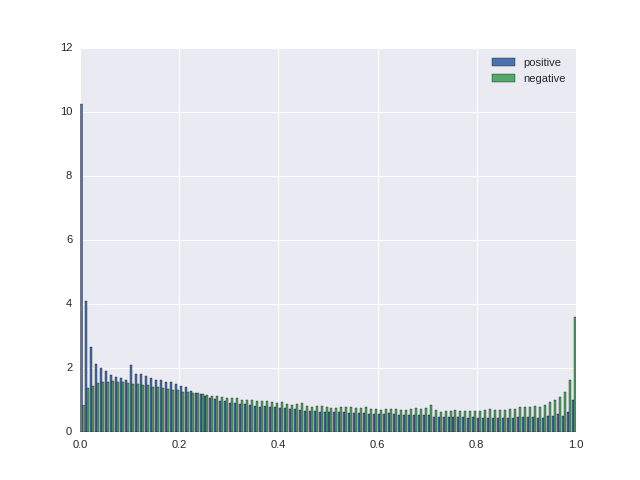

In [51]:
x=train_data.ix[train_data['is_listened']==0, 'similarity']
y=train_data.ix[train_data['is_listened']==1, 'similarity']
plt.hist((x,y), normed=True, bins=100)
plt.legend(['positive','negative'])

<IPython.core.display.Javascript object>


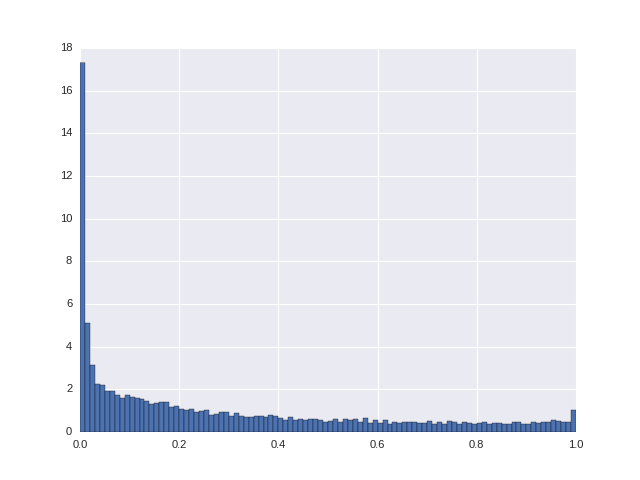

(array([ 17.30600046,   5.1310509 ,   3.1228118 ,   2.25424839,
          2.19902182,   1.94297133,   1.94297133,   1.73210622,
          1.58148829,   1.71704443,   1.63671487,   1.5714471 ,
          1.53630291,   1.46099395,   1.29029362,   1.3455202 ,
          1.38568498,   1.41580857,   1.18988167,   1.22502585,
          1.07942852,   1.01416075,   1.09951091,   0.92881058,
          0.97399596,   1.05432553,   0.81333684,   0.83341923,
          0.92378999,   0.95391357,   0.73802787,   0.90872819,
          0.73300727,   0.68782189,   0.68280129,   0.76313086,
          0.74304847,   0.69284249,   0.78321325,   0.77317205,
          0.65267771,   0.57736874,   0.68782189,   0.57234814,
          0.61251293,   0.55226575,   0.61753352,   0.58740994,
          0.54724516,   0.48699798,   0.53218336,   0.59243053,
          0.4568744 ,   0.59243053,   0.55728635,   0.62255412,
          0.48699798,   0.65267771,   0.436792  ,   0.54724516,
          0.41168902,   0.54724516,   0.

In [59]:
x=test_data['similarity']
plt.hist(x, normed=True, bins=100)

In [60]:
train_data['similarity'].to_csv('./train_similarity.csv')
test_data['similarity'].to_csv('./test_similarity.csv')